In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import torch
import torch.nn as nn
import torch.optim as optim
!pip install torchinfo
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.graphics.api import qqplot

from itertools import product
from tqdm.notebook import tqdm

In [ ]:
traffic_df = pd.read_csv('traffic.csv')
traffic_df.head()

,DateTime,Junction,Vehicles,ID
0,01-11-2015 00:00,1,15,20151101001
1,01-11-2015 01:00,1,13,20151101011
2,01-11-2015 02:00,1,10,20151101021
3,01-11-2015 03:00,1,7,20151101031
4,01-11-2015 04:00,1,9,20151101041


In [ ]:
traffic_df.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [ ]:
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'], errors='coerce', format='%d-%m-%Y %H:%M')
# set datetime to index
traffic_df.set_index('DateTime',inplace=True)
# check for null values
traffic_df.isnull().sum()

Junction    0
Vehicles    0
ID          0
dtype: int64

In [ ]:
junc1 = traffic_df[traffic_df['Junction']==1]
junc1.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [ ]:
daily_junc1 = junc1.Vehicles.resample('D').mean()
daily_junc1

DateTime
2015-11-01    13.625000
2015-11-02    22.750000
2015-11-03    22.666667
2015-11-04    20.750000
2015-11-05    19.333333
                ...    
2017-06-26    73.916667
2017-06-27    91.125000
2017-06-28    86.666667
2017-06-29    86.916667
2017-06-30    78.458333
Freq: D, Name: Vehicles, Length: 608, dtype: float64

<Axes: xlabel='DateTime'>

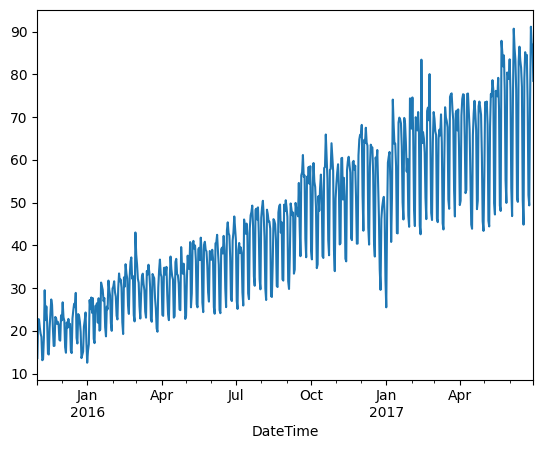

In [ ]:
daily_junc1.shape
daily_junc1.plot()

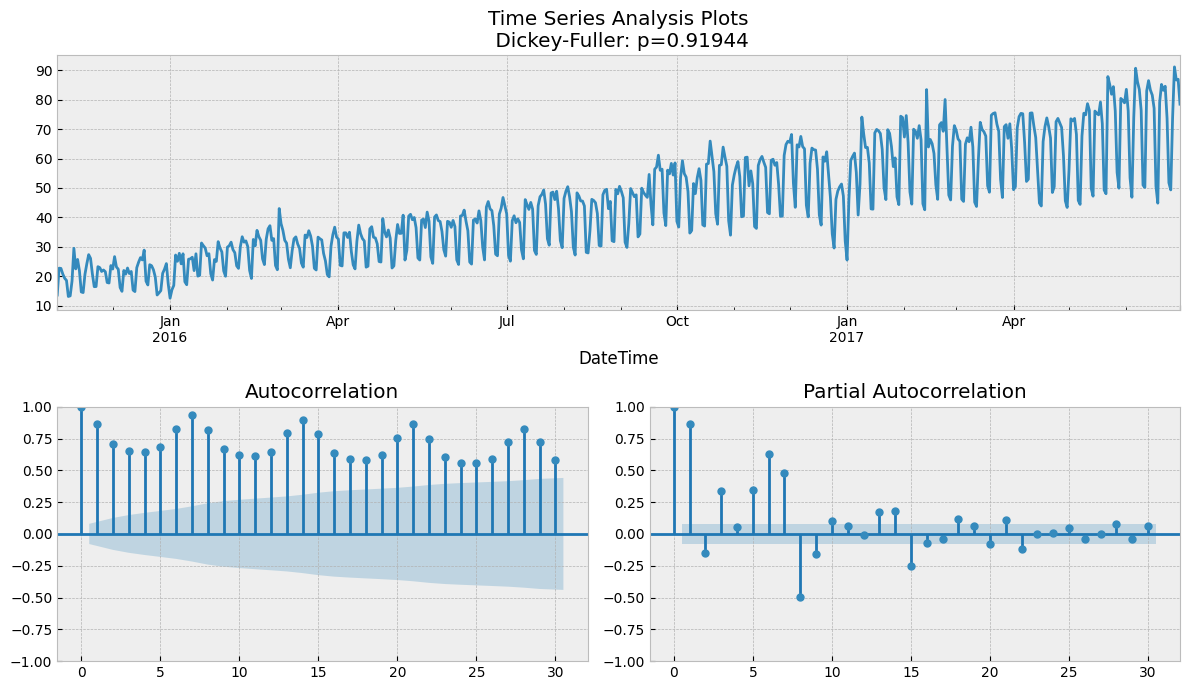

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
tsplot(daily_junc1, lags=30)

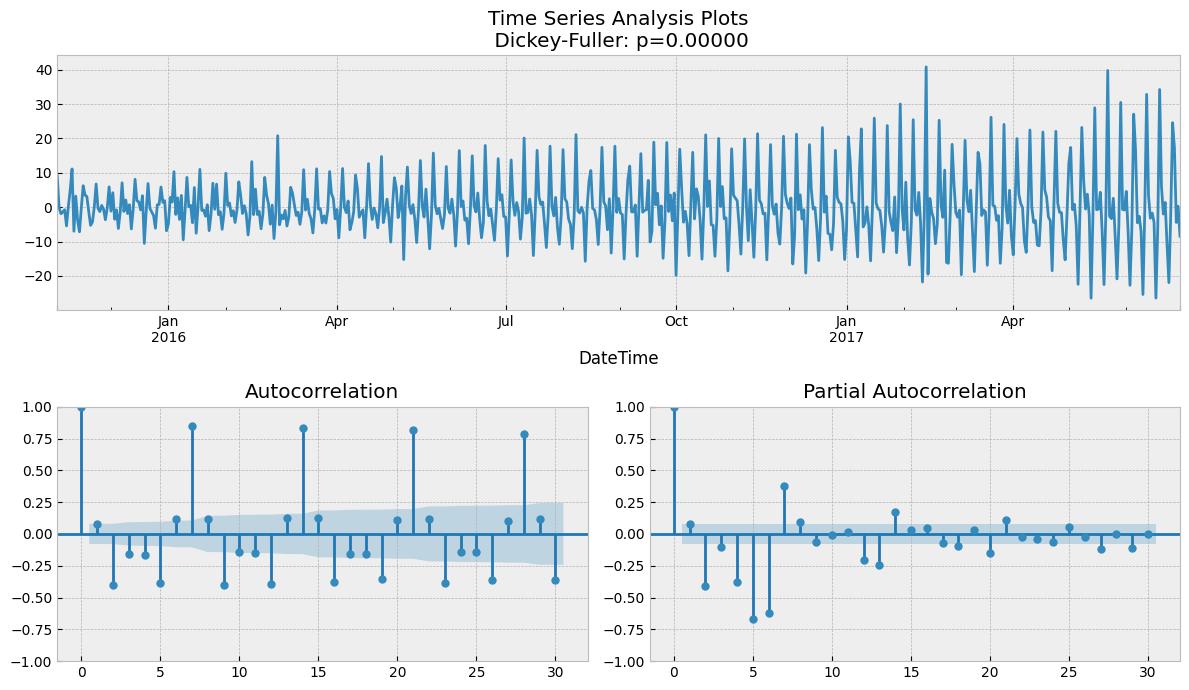

In [ ]:
daily_diff = daily_junc1 - daily_junc1.shift(1)
tsplot(daily_diff[1:], lags=30)

Parameters of SARIMA

First order differencing -> d = 1 \ ACF kind of drops after lag 1 -> q = 1 \ PACF kind of drops after lag 1 -> p = 1 \ Seasonality -> s = 7 \ Seasonal component first order differencing -> D = 1 \ Seasonal component ACF drops after lag=seasonality -> Qs = 1 \ Seasonal component PACF kind of significant at lag=seasonality, 2* seasonality -> Ps = 2

In [ ]:
# setting initial values and some bounds for them
ps = range(1, 3)
d=1
qs = range(1, 3)
Ps = range(1, 3)
D=1
Qs = range(1, 3)
s = 7 # season length

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(daily_junc1, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [ ]:
result_table.head()

,parameters,aic
0,"(1, 2, 1, 2)",3175.079110
1,"(1, 2, 1, 1)",3179.557656
2,"(2, 2, 2, 2)",3180.096409
3,"(2, 2, 1, 1)",3180.324096
4,"(1, 2, 2, 1)",3181.036409


In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(daily_junc1, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                          Vehicles   No. Observations:                  608
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 7)   Log Likelihood               -1580.540
Date:                           Mon, 29 Apr 2024   AIC                           3175.079
Time:                                   20:07:27   BIC                           3205.858
Sample:                               11-01-2015   HQIC                          3187.061
                                    - 06-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8313      0.035     23.969      0.000       0.763       0.899
ma.L1         -1.3776      0.036    -38.418

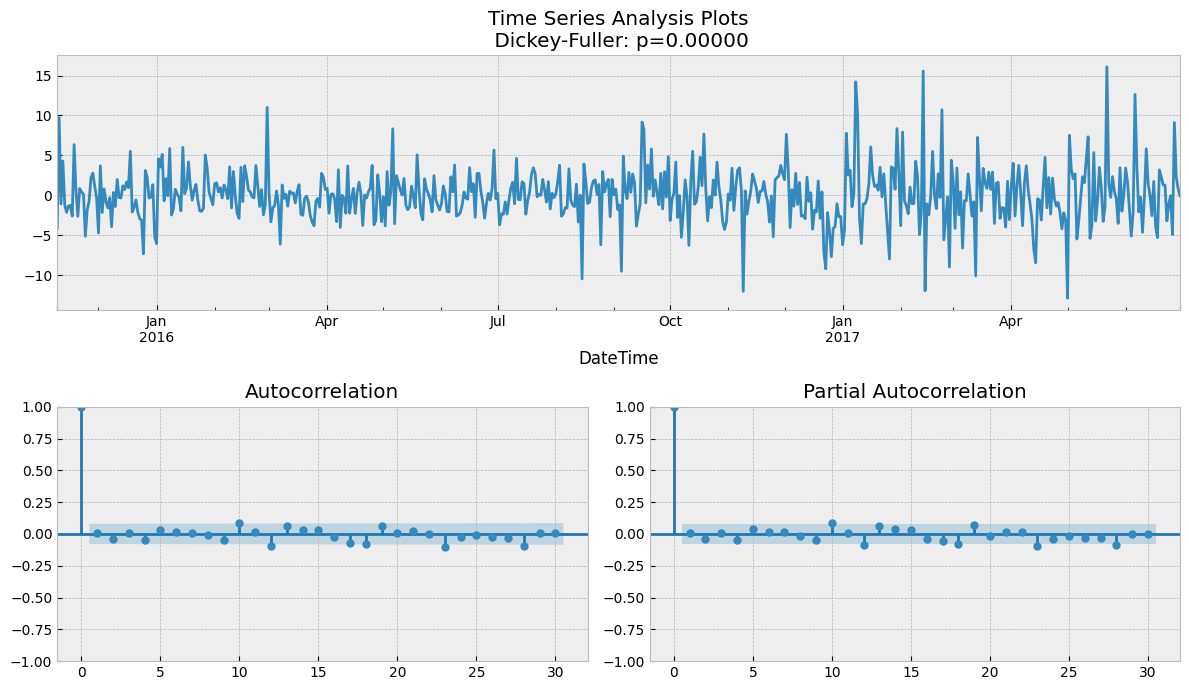

In [ ]:
tsplot(best_model.resid[7+1:], lags=30)

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

2017-07-01    55.463226
2017-07-02    52.151639
2017-07-03    80.667716
2017-07-04    87.824470
2017-07-05    84.994671
2017-07-06    85.680241
2017-07-07    77.798363
2017-07-08    54.782700
2017-07-09    51.620578
2017-07-10    80.511638
2017-07-11    88.013470
2017-07-12    85.233730
2017-07-13    86.022957
2017-07-14    78.137508
2017-07-15    54.957859
2017-07-16    51.803373
2017-07-17    80.942693
2017-07-18    88.683089
2017-07-19    85.873201
2017-07-20    86.697227
2017-07-21    78.754128
2017-07-22    55.371207
2017-07-23    52.186632
2017-07-24    81.534337
2017-07-25    89.479018
2017-07-26    86.618529
2017-07-27    87.458245
2017-07-28    79.444657
2017-07-29    55.853262
2017-07-30    52.629384
2017-07-31    82.169601
Freq: D, Name: predicted_mean, dtype: float64

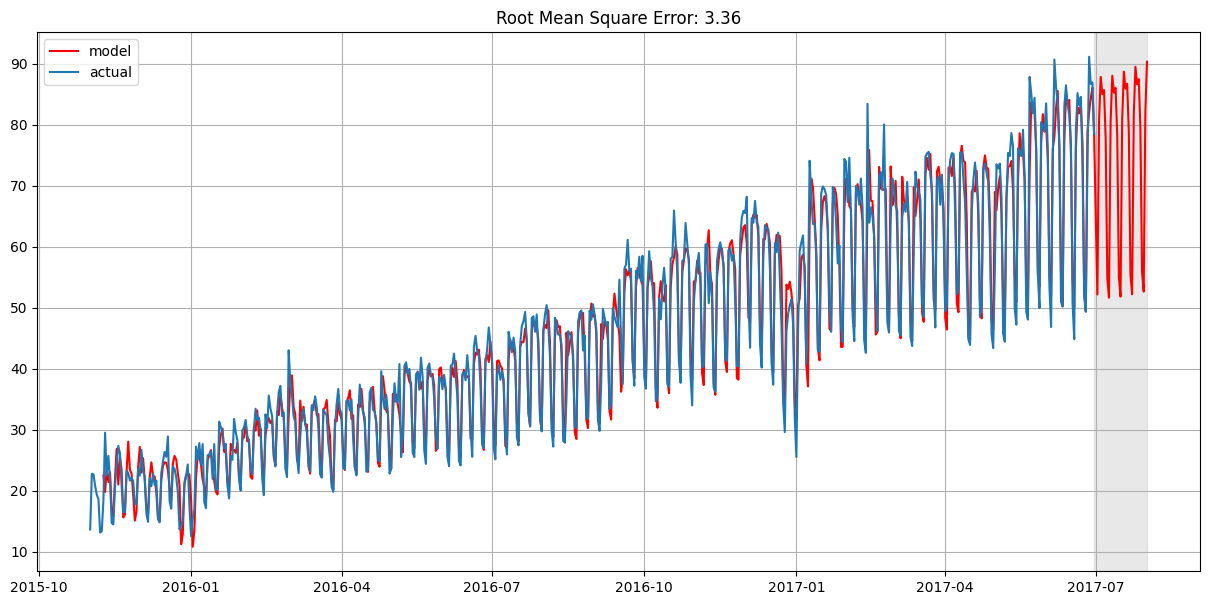

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    #data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = pd.concat([data['sarima_model'], forecast])
    # calculate error, again having shifted on s+d steps from the beginning
    #error = mean_absolute_percentage_error(data[s+d:-1].values, data['sarima_model'][s+d:].values)
    error = root_mean_squared_error(data[s+d:-1].values, data['sarima_model'][s+d:].values)

    plt.figure(figsize=(15, 7))
    #plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.title("Root Mean Square Error: {0:.2f}".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-2], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(daily_junc1, label="actual")
    plt.legend()
    plt.grid(True);
plotSARIMA(daily_junc1, best_model, 30)
sarima_forecast = best_model.predict(start = daily_junc1.shape[0], end = daily_junc1.shape[0]+30)
sarima_forecast

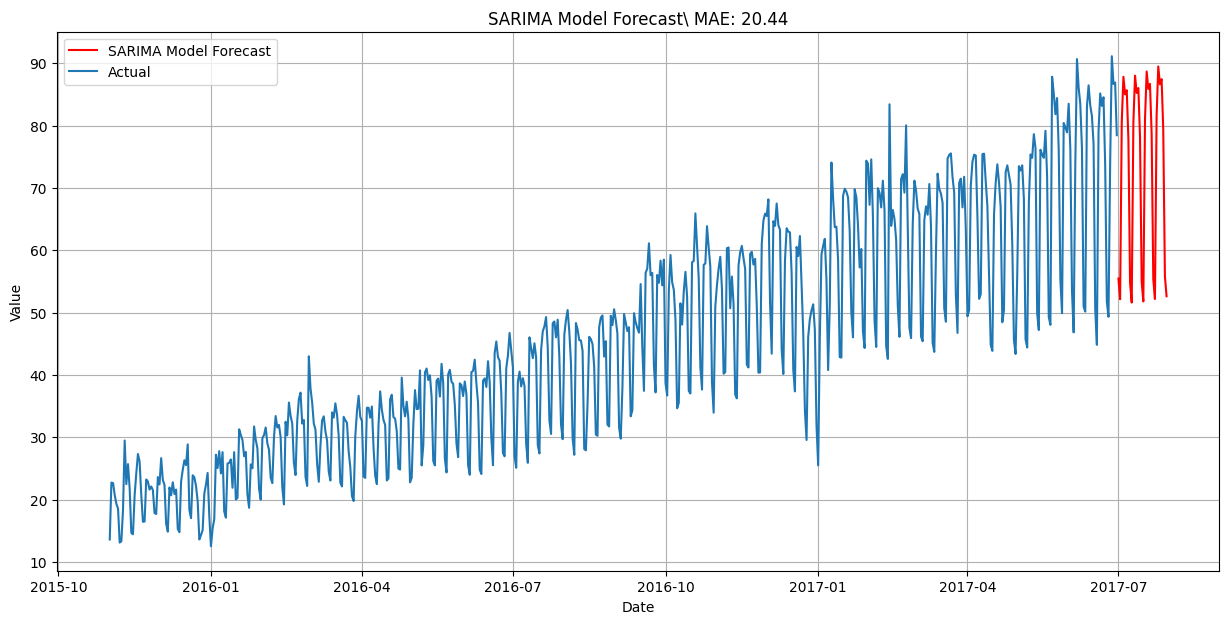

2017-07-01    55.463226
2017-07-02    52.151639
2017-07-03    80.667716
2017-07-04    87.824470
2017-07-05    84.994671
2017-07-06    85.680241
2017-07-07    77.798363
2017-07-08    54.782700
2017-07-09    51.620578
2017-07-10    80.511638
2017-07-11    88.013470
2017-07-12    85.233730
2017-07-13    86.022957
2017-07-14    78.137508
2017-07-15    54.957859
2017-07-16    51.803373
2017-07-17    80.942693
2017-07-18    88.683089
2017-07-19    85.873201
2017-07-20    86.697227
2017-07-21    78.754128
2017-07-22    55.371207
2017-07-23    52.186632
2017-07-24    81.534337
2017-07-25    89.479018
2017-07-26    86.618529
2017-07-27    87.458245
2017-07-28    79.444657
2017-07-29    55.853262
2017-07-30    52.629384
2017-07-31    82.169601
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plotSARIMA(series, model, n_steps):
    """
    Plots SARIMA model predictions against actual values and displays RMSE and MAE.

    series - dataset with timeseries
    model - fitted SARIMA model
    n_steps - number of steps to predict in the future
    """
    # Create a copy of the series
    data = series.copy()

    # Add SARIMA model predictions to the data
    data['sarima_model'] = model.fittedvalues
    data['sarima_model'][:len(series)] = np.nan  # Shift to align with original series

    # Forecast future values
    forecast = model.predict(start=len(series), end=len(series) + n_steps - 1)
    forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=n_steps, freq=series.index.inferred_freq)
    forecast = pd.Series(forecast, index=forecast_index)
    data['sarima_model'] = pd.concat([data['sarima_model'], forecast])

    # Calculate RMSE and MAE
    actual_values = series[-n_steps:]  # Last `n_steps` actual values
    forecast_values = forecast
    rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
    mae = mean_absolute_error(actual_values, forecast_values)

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(data['sarima_model'], color='r', label='SARIMA Model Forecast')
    plt.plot(series, label='Actual')
    plt.title(f"SARIMA Model Forecast\ MAE: {mae:.2f}")
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming `daily_junc1` is your time series dataset and `best_model` is your fitted SARIMA model
n_steps = 30  # Number of steps to predict in the future
plotSARIMA(daily_junc1, best_model, n_steps)
sarima_forecast = best_model.predict(start = daily_junc1.shape[0], end = daily_junc1.shape[0]+30)
sarima_forecast